# LDA and Document Similarity

We are again working with the same fake news articles supplied by Kaggle.

**I do not endorse and am not expressing any political affiliation or intent expressed in the articles in this dataset.**

We will explain LDA and train an LDA model on this corpus of fake news to see what topics emerge.

We will hold out some documents for testing to infer their topic distributions and compare them to the rest of the corpus to find the most similar documents.

We use the [gensim](https://radimrehurek.com/gensim/models/ldamodel.html) package to do this, as it is highly optimised in C and has many features that make the implementation easy to use and very flexible.

In [1]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

Read in data; only keep essential columns and English language articles

In [2]:
df = pd.read_csv('fake.csv', usecols = ['uuid','author','title','text','language','site_url','country'])
df = df[df.language == 'english']
df = df[df['text'].map(type) == str]
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,uuid,author,title,text,language,site_url,country
0,adab643227aafa4bfe3154ecf15f6640a0c8b5ad,Bill Sardi,Will Hillary Select Her Own Prosecutors?,"By Bill Sardi November 1, 2016 Journalist Carl...",english,lewrockwell.com,US
1,9fc7e6bf901433afe4672b846cad144bd2abaf4f,Jameson Parker,Trump Has Hissy Fit After Reporter Points Out ...,"October 26, 2016 Trump Has Hissy Fit After Rep...",english,ifyouonlynews.com,US
2,a5842a9de5d6bc31ee5248d1d069321d29c4c4c3,Grant Stern,A Congressman Just Revealed Who Is Behind Come...,Comments \nDemocratic Rep. Elijah Cummings (D-...,english,occupydemocrats.com,US
3,551d1d064a33d61c13f7d9d0069dd55bb5aa0738,NaN,"Fun, Safe Trick-Or-Treating Alternatives - The...",Report: Friend Has Been Going By Middle Name T...,english,theonion.com,US
4,fe070842076caeed33954c33d99e264a63f7d50b,Alex Ansary,Oregon Standoff Acquittal Sparks Fears of New ...,Oregon Standoff Acquittal Sparks Fears of New ...,english,amtvmedia.com,US


Define some functions to clean and tokenize the data

In [3]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

In [4]:
stop_words = stopwords.words('english')

In [5]:
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

In [6]:
stemmer = PorterStemmer()

In [7]:
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

In [8]:
def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [9]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 12357 articles: 4.558518060048422 min


In [62]:
df.head()

,uuid,author,title,text,language,site_url,country,tokenized
0,adab643227aafa4bfe3154ecf15f6640a0c8b5ad,Bill Sardi,Will Hillary Select Her Own Prosecutors?,"By Bill Sardi November 1, 2016 Journalist Carl...",english,lewrockwell.com,US,"[bill, sardi, novemb, journalist, carl, bernst..."
1,9fc7e6bf901433afe4672b846cad144bd2abaf4f,Jameson Parker,Trump Has Hissy Fit After Reporter Points Out ...,"October 26, 2016 Trump Has Hissy Fit After Rep...",english,ifyouonlynews.com,US,"[octob, trump, hissi, fit, report, point, paus..."
2,a5842a9de5d6bc31ee5248d1d069321d29c4c4c3,Grant Stern,A Congressman Just Revealed Who Is Behind Come...,Comments \nDemocratic Rep. Elijah Cummings (D-...,english,occupydemocrats.com,US,"[comment, democrat, rep, elijah, cum, dmd, ran..."
3,551d1d064a33d61c13f7d9d0069dd55bb5aa0738,NaN,"Fun, Safe Trick-Or-Treating Alternatives - The...",Report: Friend Has Been Going By Middle Name T...,english,theonion.com,US,"[report, friend, go, middl, name, whole, fuck,..."
4,fe070842076caeed33954c33d99e264a63f7d50b,Alex Ansary,Oregon Standoff Acquittal Sparks Fears of New ...,Oregon Standoff Acquittal Sparks Fears of New ...,english,amtvmedia.com,US,"[oregon, standoff, acquitt, spark, fear, new, ..."


### Get word frequency

We'll use nltk to get a word frequency (by count) here and only keep the top most used words to train the LDA model on

In [10]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

96280

In [13]:
# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('insideout', 1),
 ('suddendeath', 1),
 ('fourgam', 1),
 ('scientificsound', 1),
 ('hiredgun', 1),
 ('suchiat', 1),
 ('arriaga', 1),
 ('woodbas', 1),
 ('kerosen', 1),
 ('jeta', 1)]

In [17]:
# choose k and visually inspect the bottom 10 words of the top k
k = 15000
top_k_words = fdist.most_common(k)
top_k_words

[('trump', 26210),
 ('us', 26109),
 ('clinton', 25625),
 ('peopl', 20779),
 ('one', 20103),
 ('state', 19739),
 ('would', 18027),
 ('hillari', 16690),
 ('like', 15759),
 ('time', 15337),
 ('said', 14695),
 ('elect', 14573),
 ('new', 13439),
 ('year', 13385),
 ('american', 12821),
 ('also', 12277),
 ('use', 12047),
 ('go', 11859),
 ('presid', 11651),
 ('world', 11437),
 ('even', 11288),
 ('govern', 11227),
 ('say', 10906),
 ('get', 10840),
 ('make', 10766),
 ('war', 10608),
 ('report', 10174),
 ('email', 10023),
 ('vote', 9912),
 ('nation', 9869),
 ('mani', 9865),
 ('obama', 9666),
 ('countri', 9371),
 ('could', 9327),
 ('support', 9076),
 ('work', 9060),
 ('day', 9001),
 ('right', 8924),
 ('take', 8915),
 ('polit', 8908),
 ('know', 8784),
 ('russia', 8463),
 ('media', 8133),
 ('want', 8089),
 ('campaign', 8064),
 ('come', 8046),
 ('way', 7929),
 ('first', 7762),
 ('see', 7703),
 ('need', 7641),
 ('call', 7598),
 ('power', 7542),
 ('think', 7488),
 ('may', 7209),
 ('democrat', 7148),
 (

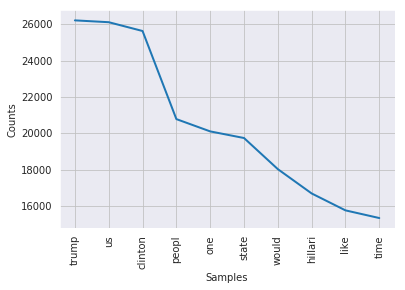

In [14]:
fdist.plot(10)

k = 50,000 is too high, as the bottom words aren't even real words and are very rarely used (once in entire corpus)

k = 15,000 is much more reasonable as these have been used at least 13 times in the corpus

In [21]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [63]:
top_k_words

{'horrend',
 'childish',
 'resolut',
 'shoddi',
 'cheer',
 'tourism',
 'proverb',
 'saad',
 'leftlean',
 'lens',
 'stripsearch',
 'hank',
 'tusi',
 'chatter',
 'undeclar',
 'cane',
 'asid',
 'sharehold',
 'nonsecur',
 'unapologet',
 'inflect',
 'search',
 'react',
 'fitt',
 'stem',
 'chlorella',
 'chore',
 'redress',
 'grant',
 'yesterday',
 'bulwark',
 'projectil',
 'pace',
 'hannah',
 'savil',
 'vall',
 'plaster',
 'wrangl',
 'rabbi',
 'svr',
 'iphon',
 'cranston',
 'bloc',
 'overcom',
 'fs',
 'laura',
 'feroci',
 'lastditch',
 'overview',
 'what',
 'heard',
 'mt',
 'ndtv',
 'flesh',
 'killari',
 'includ',
 'reich',
 'edmond',
 'fn',
 'draught',
 'atzmon',
 'hall',
 'shenanigan',
 'jam',
 'gleefulli',
 'welder',
 'md',
 'sperandeo',
 'unequ',
 'destin',
 'malala',
 'bilater',
 'carelessli',
 'steadili',
 'impati',
 'mani',
 'record',
 'pagan',
 'abram',
 'talli',
 'outlast',
 'unwav',
 'bilingu',
 'drift',
 'occurr',
 'neoconneoliberalcon',
 'syphili',
 'wachovia',
 'po',
 'ail',
 'm

In [ ]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [22]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 12357 
average document length 360.4378085295784 
minimum document length 0 
maximum document length 12116


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


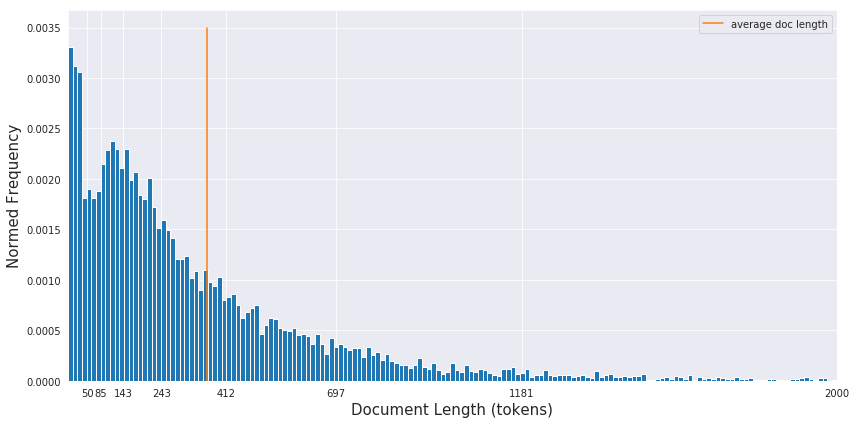

In [23]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

We can see that, compared to our histogram in exploring_news notebook, the average document length is about half when all stop words are removed and only the top 15,000 words are used.

### Drop short articles

LDA does not work very well on short documents, which we will explain later, so we will drop some of the shorter articles here before training the model.

From the histogram above, droping all articles less than 40 tokens seems appropriate.

In [24]:
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 10874 articles


In [25]:
df.head()

,uuid,author,title,text,language,site_url,country,tokenized
0,adab643227aafa4bfe3154ecf15f6640a0c8b5ad,Bill Sardi,Will Hillary Select Her Own Prosecutors?,"By Bill Sardi November 1, 2016 Journalist Carl...",english,lewrockwell.com,US,"[bill, sardi, novemb, journalist, carl, bernst..."
1,9fc7e6bf901433afe4672b846cad144bd2abaf4f,Jameson Parker,Trump Has Hissy Fit After Reporter Points Out ...,"October 26, 2016 Trump Has Hissy Fit After Rep...",english,ifyouonlynews.com,US,"[octob, trump, hissi, fit, report, point, paus..."
2,a5842a9de5d6bc31ee5248d1d069321d29c4c4c3,Grant Stern,A Congressman Just Revealed Who Is Behind Come...,Comments \nDemocratic Rep. Elijah Cummings (D-...,english,occupydemocrats.com,US,"[comment, democrat, rep, elijah, cum, dmd, ran..."
3,551d1d064a33d61c13f7d9d0069dd55bb5aa0738,NaN,"Fun, Safe Trick-Or-Treating Alternatives - The...",Report: Friend Has Been Going By Middle Name T...,english,theonion.com,US,"[report, friend, go, middl, name, whole, fuck,..."
4,fe070842076caeed33954c33d99e264a63f7d50b,Alex Ansary,Oregon Standoff Acquittal Sparks Fears of New ...,Oregon Standoff Acquittal Sparks Fears of New ...,english,amtvmedia.com,US,"[oregon, standoff, acquitt, spark, fear, new, ..."


### Split the corpus into training and testing
Here we will split the corpus into training and testing sets.

The training set will be used to train the LDA model on, while the testing set will be used to retrieve similar articles later in our recommendation algorithm.

The dataframe is already shuffled from the begining, so no need to do it again.

In [26]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.999

In [27]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [28]:
print(len(df),len(train_df),len(test_df))

10874 10866 8


# LDA

Latent Dirichlet Allocation, is an unsupervised generative model that assigns topic distributions to documents.

At a high level, the model assumes that each document will contain several topics, so that there is topic overlap within a document. The words in each document contribute to these topics. The topics may not be known a priori, and needn't even be specified, but the **number** of topics must be specified a priori. Finally, there can be words overlap between topics, so several topics may share the same words.

The model generates to **latent** (hidden) variables
1) A distribution over topics for each document
2) A distribution over words for each topics

After training, each document will have a discrete distribution over all topics, and each topic will have a discrete distribution over all words.

It is best to demonstrate this with an example. Let's say a document about the presidential elections may have a high contribution from the topics "presidential elections", "america", "voting" but have very low contributions from topics "himalayan mountain range", "video games", "machine learning" (assuming the corpus is varied enough to contain such articles); the topics "presidential elections" may have top contributing words ["vote","election","people","usa","clinton","trump",...] whereas the top contributing words in the topic "himalayan mountain range" may be ["nepal","everest","china","altitude","river","snow",....]. This very rough example should give you an idea of what LDA aims to do.

An important point to note: although I have named some topics in the example above, the model itself does not actually do any "naming" or classifying of topics. But by visually inspecting the top contributing words of a topic i.e. the discrete distribution over words for a topic, one can name the topics if necessary after training. We will show this more later.

There a several ways to implement LDA, however I will speak about collapsed gibbs sampling as I usually find this to be the easiest way to understand it.

The model initialises by assigning every word in every document to a **random** topic. Then, we iterate through each word, unassign it's current topic, decrement the topic count corpus wide and reassign the word to a new topic based on the local probability of topic assignemnts to the current document, and the global (corpus wide) probability of the word assignments to the current topic. This may be hard to understand in words, so the equations are below.

### The mathematics of collapsed gibbs sampling (cut back version)

Recall that when we iterate through each word in each document, we unassign its current topic assignment and reassign the word to a new topic. The topic we reassign the word to is based on the probabilities below.

$$
P\left(\text{document "likes" the topic}\right) \times P\left(\text{topic "likes" the word } w'\right)
$$

$$
\Rightarrow \frac{n_{i,k}+\alpha}{N_i-1+K\alpha} \times \frac{m_{w',k}+\gamma}{\sum_{w\in V}m_{w,k} + V\gamma}
$$

where

$n_{i,k}$ - number of word assignments to topic $k$ in document $i$

$n_{i,k}$ - number of assignments to topic $k$ in document $i$

$\alpha$ - smoothing parameter (hyper parameter - make sure probability is never 0)

$N_i$ - number of words in document $i$

$-1$ - don't count the current word you're on

$K$ - total number of topics


$m_{w',k}$ - number of assignments, corpus wide, of word $w'$ to topic $k$

$m_{w',k}$ - number of assignments, corpus wide, of word $w'$ to topic $k$

$\gamma$ - smoothing parameter (hyper parameter - make sure probability is never 0)

$\sum_{w\in V}m_{w,k}$ - sum over all words in vocabulary currently assigned to topic $k$

$V$ size of vocabulary i.e. number of distinct words corpus wide

### Notes and Uses of LDA

LDA has many uses; understanding the different varieties topics in a corpus (obviously), getting a better insight into the type of documents in a corpus (whether they are about news, wikipedia articles, business documents), quantifying the most used / most important words in a corpus, and even document similarity and recommendation.

LDA does not work well with very short documents, like twitter feeds, as explained here [[1]](https://pdfs.semanticscholar.org/f499/5dc2a4eb901594578e3780a6f33dee02dad1.pdf) [[2]](https://stackoverflow.com/questions/29786985/whats-the-disadvantage-of-lda-for-short-texts), which is why we dropped articles under 40 tokens previously. Very briefly, this is because the model infers parameters from observations and if there are not enough observations (words) in a document, the model performs poorly. For short texts, although yet to be rigoursly tested, it may be best to use a [biterm model](https://pdfs.semanticscholar.org/f499/5dc2a4eb901594578e3780a6f33dee02dad1.pdf).

Unlike the word2vec algorithm, which performs extremely well with full structured sentences, LDA is a bag of words model, meaning word order in a document doesnt count. This also means that stopwords and rare words should be excluded, so that the model doesnt overcompensate for very frequent words and very rare words, both of which do not contribute to general topics.

#### Hyperparameters

LDA has 2 hyperparameters: $\alpha$ and $\eta$

$\alpha$ - A low value for $\alpha$ means that documents have only a low number of topics contributing to them. A high value of $\alpha$ yields the inverse, meaning the documents appear more alike within a corpus.

$\eta$ - A low value for $\eta$ means the topics have a low number of contributing words. A high value of $\eta$ yields the inverse, meaning topics will have word overlap and appear more alike.

The values of $\alpha$ and $\eta$ really depend on the application, and may need to be tweaked several times before the desired results are found... even then, LDA is non-deterministic since parameters are randomly initialised, so the outcome of any run of the model can never be known in advance.

In [29]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [30]:
dictionary,corpus,lda = train_lda(train_df)

Time to train LDA model on  10874 articles:  9.67836515903473 min


### Let's inspect some topics!

Bear in mind, when we see the words they may seem shortened. Recall this is because of our stemming function we previously implemented.

In [31]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(70,
  '0.017*"sex" + 0.016*"alleg" + 0.012*"claim" + 0.011*"servic" + 0.008*"former" + 0.008*"lawsuit" + 0.008*"name" + 0.008*"report" + 0.008*"mccabe" + 0.008*"file" + 0.008*"record" + 0.008*"accord" + 0.007*"agent" + 0.007*"involv" + 0.007*"governor" + 0.006*"toni" + 0.006*"regist" + 0.006*"case" + 0.006*"princ" + 0.006*"deni"'),
 (53,
  '0.020*"use" + 0.020*"system" + 0.016*"technolog" + 0.014*"program" + 0.012*"space" + 0.011*"inform" + 0.011*"develop" + 0.010*"work" + 0.008*"homeless" + 0.008*"new" + 0.008*"creat" + 0.007*"comput" + 0.007*"everi" + 0.007*"test" + 0.006*"devic" + 0.006*"intellectu" + 0.006*"ident" + 0.006*"type" + 0.005*"tech" + 0.005*"screen"'),
 (54,
  '0.036*"bank" + 0.021*"money" + 0.015*"economi" + 0.012*"econom" + 0.011*"tax" + 0.010*"govern" + 0.010*"us" + 0.010*"financi" + 0.009*"billion" + 0.009*"debt" + 0.009*"dollar" + 0.008*"pay" + 0.008*"year" + 0.008*"rate" + 0.007*"system" + 0.007*"busi" + 0.006*"cash" + 0.006*"account" + 0.006*"central" + 0.006*"i

#### We can inspect individual topics as such

Note that if you re run the model again, as it is non-deterministic, word contributions to topics and topic ID's will change.

#### This topic is about court cases

In [34]:
lda.show_topic(topicid=4, topn=20)

[('polic', 0.06505781),
 ('offic', 0.040705867),
 ('gun', 0.028898247),
 ('kill', 0.020654462),
 ('law', 0.015464839),
 ('cop', 0.015305888),
 ('crime', 0.014937176),
 ('murder', 0.014605483),
 ('dog', 0.014254837),
 ('arrest', 0.014174191),
 ('use', 0.0121619785),
 ('shot', 0.010991583),
 ('man', 0.010464065),
 ('shoot', 0.010320522),
 ('peopl', 0.009723843),
 ('report', 0.008955391),
 ('attack', 0.008793701),
 ('enforc', 0.00853673),
 ('death', 0.007988593),
 ('arm', 0.0077329436)]

#### This topic is about (supposedly) Illegal Immigration

In [35]:
lda.show_topic(topicid=85, topn=20)

[('intellig', 0.052133244),
 ('inform', 0.04934833),
 ('hack', 0.029341977),
 ('spi', 0.02879106),
 ('use', 0.028576909),
 ('nsa', 0.024121422),
 ('email', 0.023776183),
 ('agenc', 0.023397544),
 ('hacker', 0.022601675),
 ('access', 0.020270253),
 ('address', 0.020078758),
 ('databas', 0.01828748),
 ('cnn', 0.01819145),
 ('name', 0.016520554),
 ('cyber', 0.016337255),
 ('us', 0.01620269),
 ('read', 0.015844246),
 ('person', 0.01371542),
 ('network', 0.012339248),
 ('work', 0.012242105)]

#### This topic is about Religion

In [36]:
lda.show_topic(topicid=75, topn=20)

[('god', 0.11103941),
 ('jesu', 0.043968245),
 ('church', 0.042551614),
 ('christian', 0.030010344),
 ('christ', 0.022106066),
 ('religion', 0.019571636),
 ('bibl', 0.017736752),
 ('faith', 0.017063642),
 ('day', 0.016760793),
 ('man', 0.016556038),
 ('lord', 0.013194293),
 ('teach', 0.013190931),
 ('spirit', 0.0111499),
 ('word', 0.010965851),
 ('time', 0.0107792225),
 ('world', 0.010719113),
 ('satan', 0.010115308),
 ('believ', 0.010093649),
 ('america', 0.010030346),
 ('sin', 0.009795661)]

#### This topic is about Climate Change

In [37]:
lda.show_topic(topicid=39, topn=20)

[('clinton', 0.16819087),
 ('hillari', 0.12707646),
 ('bill', 0.023684993),
 ('presid', 0.015604944),
 ('lie', 0.010432842),
 ('state', 0.008733706),
 ('corrupt', 0.008077591),
 ('secretari', 0.007538799),
 ('hous', 0.00695247),
 ('support', 0.0064013833),
 ('crimin', 0.006335285),
 ('liar', 0.006032654),
 ('like', 0.0054410873),
 ('obama', 0.00514863),
 ('former', 0.005092377),
 ('run', 0.0050484273),
 ('democrat', 0.0048131053),
 ('ryan', 0.0047954163),
 ('she', 0.004260266),
 ('white', 0.0041438346)]

What the about above means, is that topic 4 has top contributing words ["judge","case","court",...], which indicates the topic is about court cases. Topic 75 has top contributing words ["god","christian","love",...], which indicates the topic is about religion.

Now, not only can we see the word contribution for each topic, but we can also visualise the topic contribution for each article.

In [38]:
# select and article at random from train_df
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,7])
print(random_article_index)

6342


In [ ]:
#df.iloc[row, column]

In [42]:
data = pd.read_csv('https://s3-eu-west-1.amazonaws.com/shanebucket/downloads/uk-500.csv')
data['id'] = [np.random.randint(0,1000) for x in range(data.shape[0])]
data.head(5)

,first_name,last_name,company_name,address,city,county,postal,phone1,phone2,email,web,id
0,Aleshia,Tomkiewicz,Alan D Rosenburg Cpa Pc,14 Taylor St,St. Stephens Ward,Kent,CT2 7PP,01835-703597,01944-369967,atomkiewicz@hotmail.com,http://www.alandrosenburgcpapc.co.uk,147
1,Evan,Zigomalas,Cap Gemini America,5 Binney St,Abbey Ward,Buckinghamshire,HP11 2AX,01937-864715,01714-737668,evan.zigomalas@gmail.com,http://www.capgeminiamerica.co.uk,730
2,France,Andrade,"Elliott, John W Esq",8 Moor Place,East Southbourne and Tuckton W,Bournemouth,BH6 3BE,01347-368222,01935-821636,france.andrade@hotmail.com,http://www.elliottjohnwesq.co.uk,512
3,Ulysses,Mcwalters,"Mcmahan, Ben L",505 Exeter Rd,Hawerby cum Beesby,Lincolnshire,DN36 5RP,01912-771311,01302-601380,ulysses@hotmail.com,http://www.mcmahanbenl.co.uk,364
4,Tyisha,Veness,Champagne Room,5396 Forth Street,Greets Green and Lyng Ward,West Midlands,B70 9DT,01547-429341,01290-367248,tyisha.veness@hotmail.com,http://www.champagneroom.co.uk,659


In [46]:
data.iloc[1,1]

'Zigomalas'

In [39]:
print(train_df.iloc[random_article_index,3])

Email 
Donald Trump’s campaign debuted a dark new attack ad on Tuesday, looking to further its portrayal of Hillary Clinton as a corrupt politician and doubling down on allegations that she grew wealthy through “pay-to-play politics.”The TV spot hits Clinton, the Democratic presidential nominee, on controversies related to her family’s foundation, stating that “staggering amounts of cash poured into the Clinton Foundation from criminals, dictators, countries that hate America” and that “Hillary cut deals for donors.” 
Clinton’s charitable foundation has faced intense scrutiny this election over concerns about possible conflicts of interest because it took in money from corporations and foreign governments. Clinton has repeatedly denied, however, that her work as secretary of state was compromised by the foundation’s work or that she gave any special privileges to its donors.The Clintons have also said that the foundation, which contributes to AIDS relief abroad, among other charitable 

In [47]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

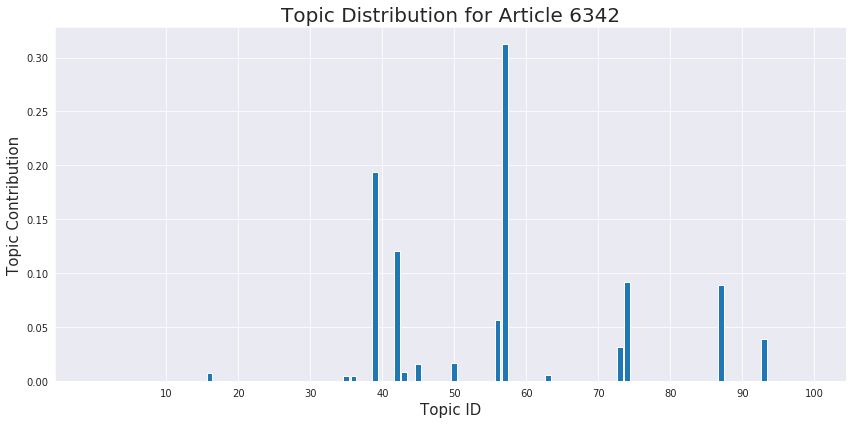

In [48]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

Ok, so clearly this document has various contributions from different topics. But what are these topics? Lets find out!

In [49]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

57 [('elect', 0.045760497), ('vote', 0.04370875), ('trump', 0.040303126), ('republican', 0.022525098), ('voter', 0.01887329), ('clinton', 0.01771686), ('hillari', 0.016180813), ('democrat', 0.015868653), ('poll', 0.014993911), ('candid', 0.013047039)] 

39 [('clinton', 0.16819087), ('hillari', 0.12707646), ('bill', 0.023684993), ('presid', 0.015604944), ('lie', 0.010432842), ('state', 0.008733706), ('corrupt', 0.008077591), ('secretari', 0.007538799), ('hous', 0.00695247), ('support', 0.0064013833)] 

42 [('million', 0.04762784), ('foundat', 0.0392751), ('fund', 0.029725742), ('money', 0.023847796), ('compani', 0.021488909), ('donat', 0.018150434), ('manag', 0.014651369), ('firm', 0.013493902), ('busi', 0.012974453), ('paid', 0.010887562)] 

74 [('govern', 0.027559325), ('american', 0.027050026), ('peopl', 0.017062979), ('power', 0.016647052), ('polit', 0.014063897), ('us', 0.013929647), ('presid', 0.011823837), ('rule', 0.0117991045), ('law', 0.011452797), ('elect', 0.011412619)] 

87

Let's interpret this.

Topic 9  - Protests

Topic 72 - Middl Eastern Countries

Topic 36 - Islam

Topic 55 - Power (socio political sense)

Topic 38 - Peoples actions

These are rough interpretations for these topics, most of which make sense. Reading the article we see the it is about riots in the Middle East. So the model seems to have worked well, at least in this one case.

# Similarity Queries and Unseen Data

We will now turn our attention to the test set of data which the model has not yet seen. Although the articles in *test_df* have been unseen by the model, gensim has a way of infering their topic distributions given the trained model. Of course, the correct approach to yield accurate results would be to retrain the model with these new articles part of the corpus, but this can be timely and infeasable in a real case scenario where results are needed quickly.

First, lets show how we can infer document topics for a new unseen article.

In [51]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
print(random_article_index)

3


Here's the important bit. In obtaining the BOW representation for this unseen article, gensim cleverly only considers words in the existing dictionary we used to train the model. So if there are new words in this article, they will not be considered when infering the topic distribution. This is good in that no errors arise for unseen words, but bad in that some words may be cut out, and therefore we could miss out on an accurate topic distribution for this article.

However, we mitigate this risk because the training set is very much representative of the entire corpus; 99.9% of the observations are in the training set, with only 0.01% of observations in the test set. So most, if not all, words from the test set should be in the training set's dictionary.

In [52]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,7])

In [53]:
print(test_df.iloc[random_article_index,3])

This is What Happens When a Currency Hits an All-Time Low Posted on Home » Headlines » Finance News » This is What Happens When a Currency Hits an All-Time Low 
This opportunity doesn’t always exist… but it does for now, at least for US dollar investors: 

From Simon Black, Sovereign Man : 
I’ll start with an admission that I don’t do vacations very well. Or frequently. 
Over the past ten years I’ve probably only taken a week or two off in total. 
A big part of that is a deep character flaw of me being a workaholic… but that’s a natural extension of genuinely loving all the exciting business ventures and wonderful people that I’m involved with each day. 
I do recognize, however, that taking a break is healthy, and I’m trying to get better at it. 
The last few weeks in particular have been a blur. 
My fellow executives at our agriculture business and I have been busy negotiating credit facilities with some of the largest financial institutions in the world, all while the company has bee

In [54]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

Let's do the same visual analysis as before on this new unseen document

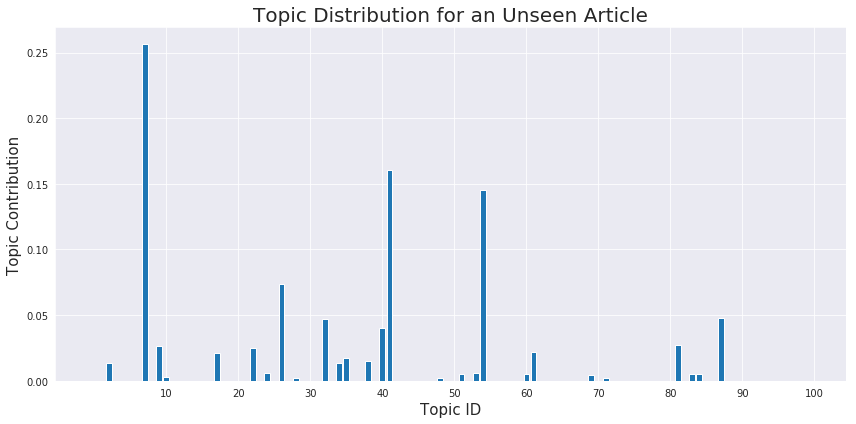

In [55]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [56]:
# print the top 8 contributing topics and their words
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

7 [('go', 0.01616183), ('like', 0.015026157), ('peopl', 0.014390786), ('one', 0.013987634), ('get', 0.013883742), ('know', 0.012414243), ('dont', 0.012137333), ('thing', 0.010237282), ('would', 0.0102047445), ('make', 0.0096762525)] 

41 [('gold', 0.07387412), ('market', 0.04374998), ('silver', 0.028306298), ('stock', 0.019919438), ('trade', 0.019834824), ('world', 0.017513042), ('price', 0.014111898), ('news', 0.010254861), ('currenc', 0.009871063), ('dollar', 0.009709361)] 

54 [('bank', 0.0362238), ('money', 0.021208195), ('economi', 0.014625944), ('econom', 0.012407288), ('tax', 0.011381656), ('govern', 0.010451751), ('us', 0.010297161), ('financi', 0.010016986), ('billion', 0.009425886), ('debt', 0.009381204)] 

26 [('one', 0.009530301), ('peopl', 0.0068088053), ('even', 0.005992591), ('mani', 0.0053585335), ('would', 0.0050575533), ('time', 0.0049902983), ('state', 0.0041241776), ('fact', 0.003956291), ('may', 0.0039281487), ('power', 0.0038968755)] 

87 [('parti', 0.035196617), 

And there we have it! An accurate topic distribution for an unseen document.

### Similarity query

Ok, now that we have a topic distribution for a new unseen document, let's say we wanted to find the most similar documents in the corpus. We can do this by comparing the topic distribution of the new document to all the topic distributions of the documents in the corpus. We use the [Jensen-Shannon distance](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) metric to find the most similar documents.

What the Jensen-Shannon distance tells us, is which documents are statisically "closer" (and therefore more similar), by comparing the divergence of their distributions. Jensen-Shannon is symmetric, unlike Kullback-Leibler on which the formula is based. This is good, because we want the similarity between documents A and B to be the same as the similarity between B and A.

The formula is described below.

For discrete distirbutions $P$ and $Q$, the Jensen-Shannon divergence, $JSD$ is defined as

$$JSD\left(P||Q\right) = \frac{1}{2}D\left(P||M\right)+\frac{1}{2}D\left(Q||M\right)$$

where $M = \frac{1}{2}\left(P+Q\right)$

and $D$ is the Kullback-Leibler divergence

$$D\left(P||Q\right) = \sum_iP(i)\log\left(\frac{P(i)}{Q(i)}\right)$$

$$\Rightarrow JSD\left(P||Q\right) = \frac{1}{2}\sum_i
\left[
P(i)\log\left(\frac{P(i)}{\frac{1}{2}\left(P(i)+Q(i)\right)}\right)
+
Q(i)\log\left(\frac{Q(i)}{\frac{1}{2}\left(P(i)+Q(i)\right)}\right)
\right]$$

The square root of the Jensen-Shannon divergence is the Jensen-Shannon Distance: $\sqrt{JSD\left ( P||Q\right )}$

**The smaller the Jensen-Shannon Distance, the more similar two distributions are (and in our case, the more similar any 2 documents are)**

We can use the scipy implementation of entropy to do this. Entropy calculates the KL divergence.

But first, we need to get all our LDA topic distributions into a dense matrix. This will enable fast and efficient computation.

We will create a dense matrix, **doc_topic_dist**, of size $M\times K$ where $M$ is the number of documents and $K$ is the number of topics.

In [57]:
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(10866, 100)

In [58]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

Let's compare the new unseen document, to the corpus, and see which articles are most similar.

In [59]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

#### Query time + most similar documents... at last!

Ok, let's be 100% clear about what we are doing here.

We are comparing the new unseen document above to the entire corpus of ~10k documents to find which one is most similar to the new document.

How are we doing that? Well, we have the new documents LDA topic distribution in stored as varibale **new_doc_distribution**, and we have the entire corpus of documents topic distributions stored in the dense matrix **doc_topic_dist**. So now, we pass each row of **doc_topic_dist** through the Jensen-Shannon function above as the Q distribution, while the P distribution remains static as **new_doc_distribution**. Then we get the smallest distances and their corresponding index in the array, which we can pass to the **train_df** dataframe to print out the most similar documents.

In [60]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)

In [61]:
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
most_similar_df['title']

1020       Global Debt Grows and Central Banks Are Buyers
2558    Sprott’s Thoughts On Gold Corrections, Pattern...
3982    Re: The Velocity Of Money In The U.S. Falls To...
7077    In The Coming Financial Wipeout, This Will Fig...
9259    Federal Reserve & Clintons Doomed [Video w/ pa...
9320    Legend Art Cashin On A Trump Presidency, The N...
9399                    The Average American Has No Money
9643    Radical Changes Are In Store For The World And...
9927                                Green Is the New Gold
9988                                        Hi-Yo Silver!
Name: title, dtype: object

I think we can see, the top most similar articles are quite similar indeed to the query article ;)

Our query article is about Trump, Huffington Post and the election. The top 10 most similar documents in the corpus also contain these topics, as their title show above. The reader can print out the full articles, or visualise the topic distributions for the most similar document and compare them to the query document to check the overlap.

## Conclusion

- After cleaning the corpus and keeping only the top 15,000 words, we reduced the unique words in the corpus by 84%
- The average document length is halved to 345 tokens after cleaning, compared to the raw version we saw in our explore notebook using word2vec
- The LDA algorithm was explained in detail
- The LDA model was able to accurately identify different topics in the fake news corpus. We visually inspected these topics to see that the top words were related
- We were able to infer a topic distribution from a new unseen document
- We quickly retrieved the most similar documents in the trained corpus when comparing to the new unseen document. These most similar documents were in fact closely related to the query document